<a href="https://colab.research.google.com/github/lom-sup/lstm/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, Sequential
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers import Activation
# from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
#from tensorflow.keras.losses import RSME
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.callbacks import ReduceLROnPlateau

In [1]:
from google.colab import files

stock = files.upload()

Saving stock.csv to stock.csv


In [4]:
stock = pd.read_csv("stock.csv")

In [5]:
#time 생성하기
# 시작 기간과 종료 기간 설정
start_period = '2005-01'
end_period = '2022-12'

# 기간 범위 생성
periods = pd.period_range(start=start_period, end=end_period, freq='M')

stock.insert(0, 'time', pd.DataFrame({'time': periods}))

In [6]:
stock['time'] = stock['time'].dt.to_timestamp() #datatime 객체로 변환
stock = stock.set_index('time') #time 열을 인덱스로


In [ ]:
#자료 앞 뒤 확인 인덱싱 등등
stock.head()

,minwages,baseinterestrate,dolexchangerate,bot,cab,cpi,nominalgdp,realgdp,kospi200
time,,,,,,,,,
2005-01-01,"2,840",3.25,"1,025.60","3,004","1,398",3.4,74678.6,3.0,121.06
2005-02-01,"2,840",3.25,"1,006.00","2,004",752,3.4,74678.6,3.0,130.85
2005-03-01,"2,840",3.25,"1,015.50","1,172","1,316",3.0,74678.6,3.0,131.97
2005-04-01,"2,840",3.25,"1,002.80","1,629","-1,735",3.1,78607.9,3.9,128.44
2005-05-01,"2,840",3.25,"1,007.70","1,961",546,3.1,78607.9,3.9,124.84


In [7]:
stock.tail()

,minwages,baseinterestrate,dolexchangerate,bot,cab,cpi,nominalgdp,realgdp,kospi200
time,,,,,,,,,
2022-08-01,"9,160",2.50,"1,337.60","-9,422","-2,912",5.7,182964.167,3.2,331.78
2022-09-01,"9,160",2.50,"1,430.20","-3,837","2,089",5.6,182964.167,3.2,318.56
2022-10-01,"9,160",3.00,"1,424.30","-6,739","1,630",5.7,185542.900,1.4,299.58
2022-11-01,"9,160",3.25,"1,318.80","-7,076",-223,5.0,185542.900,1.4,323.09
2022-12-01,"9,160",3.25,"1,264.50","-4,774","2,677",5.0,185542.900,1.4,322.02


In [8]:
stock = stock.replace(',', '', regex=True) #쉼표 없애주고?
stock = stock.astype(float) #실수형으로

In [9]:
normalization_stock = (stock - stock.mean())/stock.std() #정규화

<Axes: xlabel='time'>

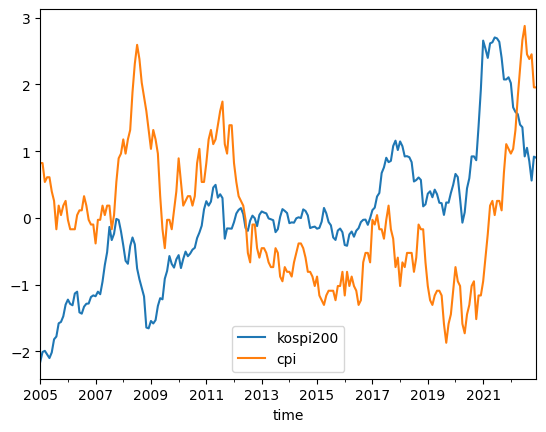

In [ ]:
normalization_stock[['kospi200', 'cpi']].plot() #목적변수와 cpi 관계 확인

In [10]:
#정규화 잘됐는지 확인
normalization_stock.head()

,minwages,baseinterestrate,dolexchangerate,bot,cab,cpi,nominalgdp,realgdp,kospi200
time,,,,,,,,,
2005-01-01,-1.367053,0.679673,-0.874782,-0.044800,-0.741846,0.822453,-1.748715,-0.132164,-2.156256
2005-02-01,-1.367053,0.679673,-1.061319,-0.335230,-0.909346,0.822453,-1.748715,-0.132164,-2.007263
2005-03-01,-1.367053,0.679673,-0.970906,-0.576867,-0.763108,0.539120,-1.748715,-0.132164,-1.990218
2005-04-01,-1.367053,0.679673,-1.091774,-0.444141,-1.554196,0.609953,-1.622261,0.307028,-2.043941
2005-05-01,-1.367053,0.679673,-1.045140,-0.347718,-0.962760,0.609953,-1.622261,0.307028,-2.098728


In [25]:
# Sequential Dataset 생성 함수
def create_sequential_dataset(data, target_variable, sequence_length, batch_size):
    input_sequences = []
    target_values = []

    # 입력 시퀀스와 타깃 값을 생성
    for i in range(len(data) - sequence_length):
        input_sequences.append(data.iloc[i:i+sequence_length, :-1].values) #마지막열인 목적변수 빼고 입력에 저장
        target_values.append(data.iloc[i:i+sequence_length, normalization_stock.columns.get_loc("kospi200")]) #목적변수값만 저장

    return target_values

In [32]:
#Sequential Dataset으로 변환

import pandas as pd
import numpy as np
import tensorflow as tf

# 설명변수: minwages, baseinterestrate, dolexchangerate, bot, cab, cpi, nominalgdp, realgdp, 
# 종속변수 : kospi200
# 인덱스: time
#데이터프레임 형태로 진행

# Sequential Dataset 생성 함수
def create_sequential_dataset(data, target_variable, sequence_length, batch_size):
    input_sequences = []
    target_values = []

    # 입력 시퀀스와 타깃 값을 생성
    for i in range(len(data) - sequence_length):
        input_sequences.append(data.iloc[i:i+sequence_length, :-1].values) #마지막열인 목적변수 빼고 입력에 저장
        target_values.append(data.iloc[i:i+sequence_length, normalization_stock.columns.get_loc("kospi200")]) #목적변수값만 저장

    # Sequential Dataset 생성
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        np.array(input_sequences), np.array(target_values),
        sequence_length=sequence_length,  # 입력 시퀀스 길이
        batch_size=batch_size  # 배치 크기
    )

    return dataset



# Sequential Dataset 생성
sequence_length = 24  # 입력 시퀀스 길이 / 주기성에 따라
batch_size = 6  # 배치 크기 / 2분기, 6개월
# step = int(np.ceil(total_train / float(batch_size)))

# "kospi200"를 타깃 변수로 선택하고, 다른 변수는 입력 변수로 선택하여 Sequential Dataset 생성
target_variable = "kospi200"
input_variables = ["minwages", "baseinterestrate", "dolexchangerate", "bot", "cab", "cpi", "nominalgdp", "realgdp"]

# 입력 데이터프레임에서 입력 변수와 타깃 변수 선택
input_data = normalization_stock[input_variables + [target_variable]]

# Sequential Dataset 생성
dataset = create_sequential_dataset(input_data, target_variable, sequence_length, batch_size)

#Sequential Dataset 확인
for batch in dataset:
    inputs, targets = batch
    print("Inputs:")
    print(inputs)
    print("Targets:")
    print(targets)
    print("-----")

dataset = pd.DataFrame(dataset)
dataset.head()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
   ...
   [ 0.21340714 -0.91391638  0.32629061 ... -1.09004474  0.50940938
     0.16063056]
   [ 0.21340714 -0.91391638  0.02554667 ... -1.30254444  0.56244034
    -0.2297627 ]
   [ 0.21340714 -0.91391638 -0.02584628 ... -1.23171121  0.56244034
    -0.2297627 ]]

  ...

  [[ 0.21340714 -0.71471765  0.20732544 ... -0.87754504  0.50940938
     0.16063056]
   [ 0.21340714 -0.71471765  0.70602742 ... -1.01921151  0.50940938
     0.16063056]
   [ 0.21340714 -0.91391638  0.32629061 ... -1.09004474  0.50940938
     0.16063056]
   ...
   [ 0.95657042 -0.71471765 -0.47220359 ... -1.01921151  0.66840563
    -0.18096355]
   [ 0.95657042 -0.71471765 -0.33039711 ... -0.66504535  0.66840563
    -0.18096355]
   [ 0.95657042 -0.71471765 -0.51407933 ... -0.73587858  0.66840563
    -0.18096355]]

  [[ 0.21340714 -0.71471765  0.70602742 ... -1.01921151  0.50940938
     0.16063056]
   [ 0.21340714 -0.91391638  0.32629061 ... -1.09004474  0.50940938
     0.16063056]
   [

,0,1
0,(((tf.Tensor(\n[-1.36705345 0.67967343 -0.874...,"((tf.Tensor(-2.1562558532672957, shape=(), dty..."
1,(((tf.Tensor(\n[-1.36705345 0.67967343 -0.863...,"((tf.Tensor(-1.8174836093082454, shape=(), dty..."
2,(((tf.Tensor(\n[-1.23823848 1.07807088 -1.455...,"((tf.Tensor(-1.2228820113082408, shape=(), dty..."
3,(((tf.Tensor(\n[-1.23823848 1.47646833 -1.544...,"((tf.Tensor(-1.4336634838523938, shape=(), dty..."
4,(((tf.Tensor(\n[-1.04997045 1.67566706 -1.679...,"((tf.Tensor(-1.1725075222020207, shape=(), dty..."


In [33]:
print(type(dataset))

<class 'pandas.core.frame.DataFrame'>


In [34]:
#데이터 분할

import numpy as np
from sklearn.model_selection import train_test_split


# 입력(X)와 타깃(Y)으로 분할
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values

# Train 및 Test 데이터로 분할
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)


In [ ]:
## model 만들고 compile 하기

model = Sequential()
model.add(LSTM(256,input_shape=(sequence_length, 8),return_sequences=True)) #input_shape은 sequence_length, 8개 설명변수 
#시퀀스 출력은 True 512차원 출력
model.add(Dropout(0.1)) #과적합 방지를 위한 드랍아웃 비율은 0.2
model.add(LSTM(128, return_sequences=True)) #LSTM 층  256차원출력
model.add(Dropout(0.1)) #드랍아웃 층
model.add(LSTM(64)) #LSTM층 128차원 출력
model.add(Dense(64, activation='tanh')) #은닉층
model.add(Dropout(0.1)) #드랍아웃 층
model.add(Dense(9, activation='tanh')) #은닉층
model.add(Dense(1)) #활성화 함수 하이퍼리퍼블릭 // relu로 바꾸는게 나을수도.
model.compile(loss='MSE', optimizer='adam' ,metrics=['accuracy'])
#model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()


In [ ]:
#모델 적합시키기

early_stopping = EarlyStopping(monitor='val_loss', patience=30)
history_m=model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=6, epochs=500, verbose=1, 
callbacks=[early_stopping])

# y_val_loss에 테스트셋으로 실험 결과의 오차 값을 저장
y_val_loss=history_m.history['val_loss']
# y_acc에 학습 셋으로 측정한 정확도의 값을 저장
y_loss=history_m.history['loss']

In [ ]:
#그림그리기

import matplotlib.pyplot as plt

# list all data in history
print(history_m.history.keys())
# summarize history for accuracy
plt.plot(history_m.history['accuracy'])
plt.plot(history_m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
